# **Sentiment Prediction of Movie Reviews using Machine Learning**
- Python, Scikit-Learn API
- Numpy, Pandas, Scipy

## Loading the Datasets

In [1]:
import numpy as np 
import pandas as pd
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [3]:
def load_data():
    global train, test, movies
    train = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
    test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
    movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
load_data()

## EDA

In [4]:
traincopy = train.copy()
traincopy

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE


In [5]:
traincopy.describe(include='all')

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


- Exploring and Checking for Null Values in the columns of train dataset**


In [6]:
traincopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [7]:
traincopy.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

- Creating a view containing all missing rows from the exploration train set

In [8]:
missing_rows = traincopy[traincopy.reviewText.isnull()]
missing_rows

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
80,lost_whimsical_journey,Bobby Jenkins,False,NaN,NEGATIVE
113,journey_jack_torrance,Amanda Watson,False,NaN,NEGATIVE
178,james_bond_mystique,Jose Mccormick,False,NaN,POSITIVE
230,mystic_enigma_john_wick,Claire Conway,False,NaN,POSITIVE
232,rick_blaine_wonder,Brittany Medina,False,NaN,POSITIVE
...,...,...,...,...,...
162571,hidden_hannibal_lecter_riddle,Howard Evans,False,NaN,POSITIVE
162573,norman_bates_michael_corleone_sherlock_holmes,Andre Schmitt,True,NaN,POSITIVE
162579,captain_jack_sparrow_destiny_tony_stark_hulk,Sherri Morrison,False,NaN,POSITIVE
162660,astonish_wonder_james_t._kirk_witch,Thomas Stone,False,NaN,NEGATIVE


- Relationship between Sentiment and Missing Rows

<Axes: >

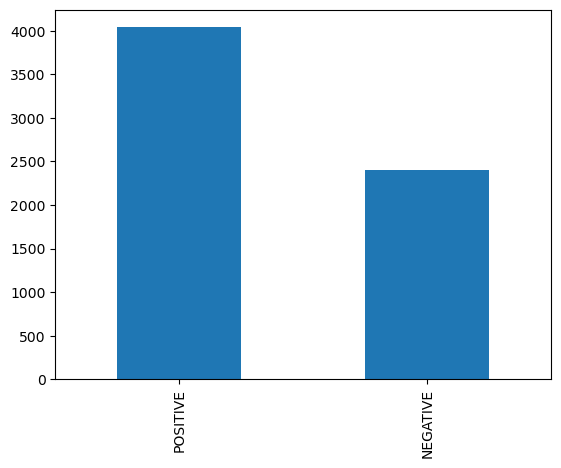

In [9]:
missing_rows.sentiment.value_counts().plot(kind='bar')

- Relationship between isFrequentReviewer and Missing Rows

<Axes: >

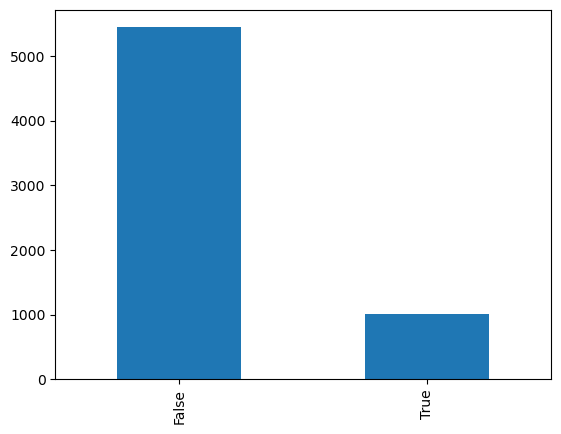

In [10]:
missing_rows.isFrequentReviewer.value_counts().plot(kind='bar')

- With the above graphs we can understand that there is a high number of missing reviews contributing to **isFrquentReviewer:False** and **Sentiment:Positive** so we continue to do the Chi2 Test

In [11]:
contingency_obs = pd.crosstab(traincopy['isFrequentReviewer'],traincopy['sentiment'], margins = False)
print(contingency_obs)

sentiment           NEGATIVE  POSITIVE
isFrequentReviewer                    
False                  35760     77429
True                   18237     31332


In [12]:
from scipy.stats.contingency import chi2_contingency
chi2_results = chi2_contingency(contingency_obs)
chi2_results

Chi2ContingencyResult(statistic=419.89235425657796, pvalue=2.5755894769493255e-93, dof=1, expected_freq=array([[37551.86493444, 75637.13506556],
       [16445.13506556, 33123.86493444]]))

- To find top-words that contribute to the POSITIVE and NEGATIVE reviews in the Train Set

In [13]:
test

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...
...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...
55311,vivid_james_t._kirk,Thomas Osborne,False,As an oddball art film that openly invites you...
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,Nicholson wears his devilish grin from his fir...
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,It's hard not be entertained by two dozen of C...


In [14]:
test.isna().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [15]:
movies.corr()

,audienceScore,runtimeMinutes
audienceScore,1.000000,0.160563
runtimeMinutes,0.160563,1.000000


In [16]:
movies

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143253,sherlock_holmes_surreal_james_bond,Sherlock Holmes Surreal James Bond,14.0,NaN,NaN,2002-08-27,NaN,90.0,"Action, Adventure, Anime",Japanese,William Sims,NaN,ADV Films,NaN
143254,mr._miyagi_katniss_everdeen_harmony,Mr. Miyagi Katniss Everdeen Harmony,NaN,NaN,NaN,NaN,NaN,99.0,Drama,English,Robert Paddock,NaN,NaN,NaN
143255,elegant_emerald_valiant_donnie_darko,Elegant Emerald Valiant Donnie Darko,71.0,NaN,NaN,NaN,NaN,43.0,Documentary,English,Roy Lovelace,NaN,NaN,NaN
143256,wonder_hermione_granger_hulk_v,Wonder Hermione Granger Hulk V,NaN,NaN,NaN,NaN,2006-11-21,63.0,Drama,English,Dwayne Clayton,NaN,NaN,NaN


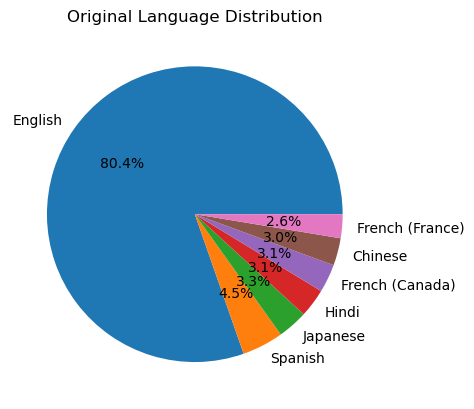

In [17]:
# Pie Chart - Original Language Distribution
language_counts = movies['originalLanguage'].value_counts()[:7]
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%')
plt.title('Original Language Distribution')
plt.show()

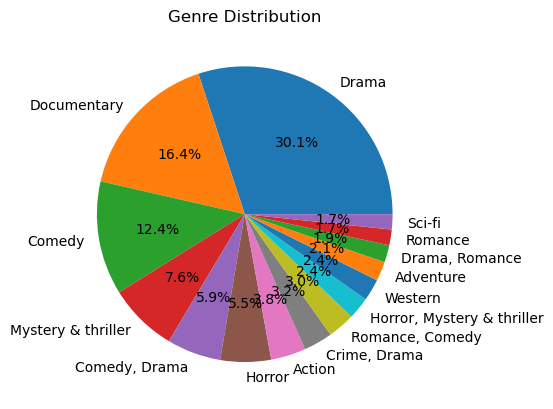

In [18]:
# Pie Chart - Original Language Distribution
genre_counts = movies['genre'].value_counts()[:15]
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%')
plt.title('Genre Distribution')
plt.show()

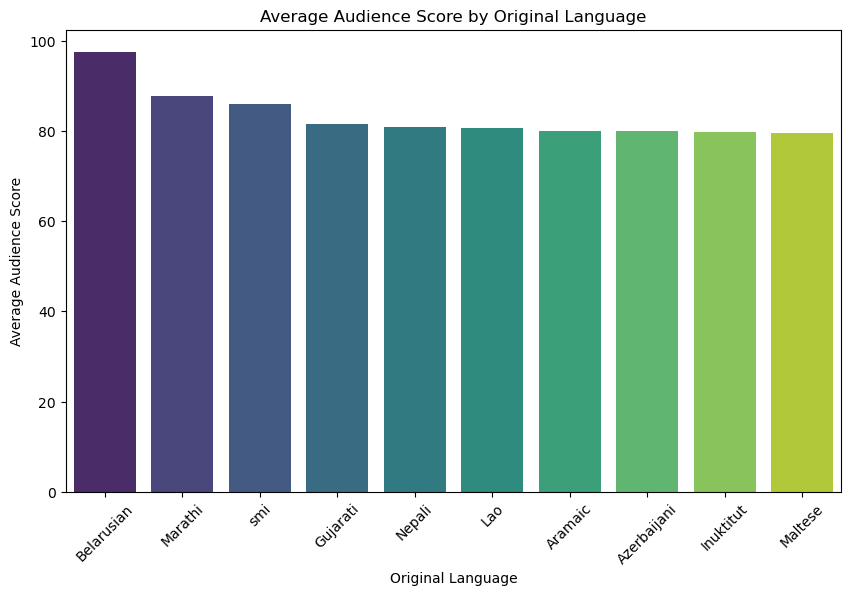

In [19]:
avg_score_by_language = movies.groupby('originalLanguage')['audienceScore'].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_score_by_language.index, y=avg_score_by_language.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Original Language')
plt.ylabel('Average Audience Score')
plt.title('Average Audience Score by Original Language')
plt.show()

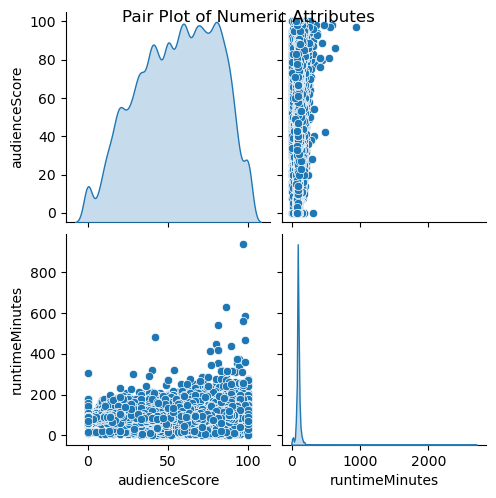

In [20]:
sns.pairplot(movies,diag_kind='kde')
plt.suptitle('Pair Plot of Numeric Attributes')
plt.show()

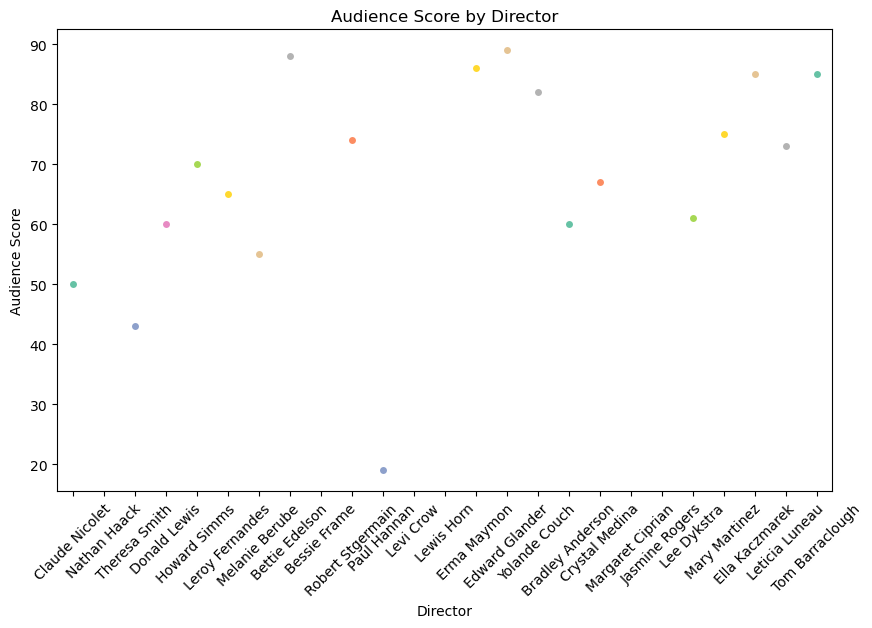

In [21]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x='director', y='audienceScore', data=movies.head(25), palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Audience Score')
plt.title('Audience Score by Director')
plt.show()

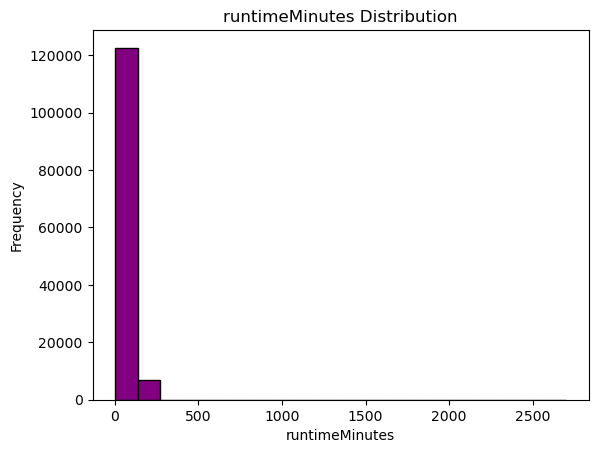

In [22]:
plt.hist(movies['runtimeMinutes'], bins=20, color='purple', edgecolor='black')
plt.xlabel('runtimeMinutes')
plt.ylabel('Frequency')
plt.title('runtimeMinutes Distribution')
plt.show()

## Preprocessing

In [23]:
train.reviewText.replace("[^a-z,A-Z]"," ",regex=True,inplace=True)
test.reviewText.replace("[^a-z,A-Z]"," ",regex=True,inplace=True)

In [24]:
def stem_word(word):
    if len(word) > 2:
        if word.endswith('sses'):
            word = word[:-2]
        elif word.endswith('ies'):
            word = word[:-2] + 'i'
        elif word.endswith('ss'):
            word = word
        elif word.endswith('s'):
            word = word[:-1]
        
        if word.endswith('eed'):
            if len(word) > 4:
                word = word[:-1]
        elif word.endswith('ed'):
            if 'v' in word[:-2]:
                word = word[:-2]
                if word.endswith('at'):
                    word += 'e'
            else:
                word = word[:-2]
        elif word.endswith('ing'):
            if 'v' in word[:-3]:
                word = word[:-3]
                if word.endswith('at'):
                    word += 'e'
            else:
                word = word[:-3]
        
        if word.endswith('y'):
            if len(word) > 2:
                if word[-2] not in ['a', 'e', 'i', 'o', 'u']:
                    word = word[:-1] + 'i'
        
        if word.endswith('ational'):
            if len(word) > 7:
                word = word[:-5] + 'e'
        elif word.endswith('tional'):
            if len(word) > 6:
                word = word[:-2]
        elif word.endswith('izer'):
            if len(word) > 4:
                word = word[:-1]
        elif word.endswith('ational'):
            if len(word) > 8:
                word = word[:-5] + 'e'
        elif word.endswith('alize'):
            if len(word) > 5:
                word = word[:-3]
        elif word.endswith('ative'):
            if len(word) > 6:
                word = word[:-5]
        
        if word.endswith('ical'):
            if len(word) > 4:
                word = word[:-2]
        elif word.endswith('ful'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ness'):
            if len(word) > 4:
                word = word[:-4]
        
        if word.endswith('icate'):
            if len(word) > 5:
                word = word[:-3]
        elif word.endswith('iciti'):
            if len(word) > 5:
                word = word[:-3]
        elif word.endswith('ical'):
            if len(word) > 4:
                word = word[:-2]
        
        if word.endswith('al'):
            if len(word) > 3:
                word = word[:-2]
        elif word.endswith('ance'):
            if len(word) > 4:
                word = word[:-4]
        elif word.endswith('ence'):
            if len(word) > 4:
                word = word[:-4]
        elif word.endswith('er'):
            if len(word) > 2:
                word = word[:-2]
        
        if word.endswith('ic'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('able'):
            if len(word) > 4:
                word = word[:-4]
        elif word.endswith('ible'):
            if len(word) > 4:
                word = word[:-4]
        
        if word.endswith('ant'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ement'):
            if len(word) > 5:
                word = word[:-5]
        elif word.endswith('ment'):
            if len(word) > 4:
                word = word[:-4]
        elif word.endswith('ent'):
            if len(word) > 2:
                word = word[:-2]
        
        if word.endswith('ion'):
            if len(word) > 3 and word[-4] in ['s', 't']:
                word = word[:-3]
        
        if word.endswith('ou'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('ism'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ate'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('iti'):
            if len(word) > 3:
                word = word[:-3]
        
        if word.endswith('ous'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ive'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ize'):
            if len(word) > 3:
                word = word[:-3]
        
        if word.endswith('al'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('er'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('ic'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('ible'):
            if len(word) > 4:
                word = word[:-4]
        elif word.endswith('ant'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ent'):
            if len(word) > 2:
                word = word[:-2]
        elif word.endswith('ism'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ate'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('iti'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ous'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ive'):
            if len(word) > 3:
                word = word[:-3]
        elif word.endswith('ize'):
            if len(word) > 3:
                word = word[:-3]
    
    return word

In [25]:
def decontracted(phrase):
    return re.sub(r"n\'t|\'re|\'s|\'d|\'ll|\'ve|\'m", lambda match: {"n't": " not", "'re": " are", "'s": " is", "'d": " had", "'ll": " will", "'ve": " have", "'m": " am"}[match.group(0)], phrase)

In [26]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()          # Convert text to lowercase
        text = re.sub(r'\d+', '', text)        # Remove numbers
        words = text.split()        # Tokenization (split text into words)
        # Remove stopwords stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'other', 'some', 'such','nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'don', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'ma']
        decontracted_words = [decontracted(word) for word in words]
        final_words = [stem_word(word).strip() for word in decontracted_words ] #if (word not in stopwords_list)
        processed_text = ' '.join(final_words)         # Join the words back into a single string
        return processed_text

In [27]:
train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick s first movie since s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you re thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE


In [28]:
train.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [29]:
def topwords(df, column):
    from collections import Counter
    df = df.astype('str')    # Load the file into a DataFrame
    positive_reviews = df[df['sentiment'] == 'POSITIVE']    # Separate positive and negative reviews
    negative_reviews = df[df['sentiment'] == 'NEGATIVE']
    positive_text = ' '.join(positive_reviews[column].tolist())    # Combine all positive reviews into a single text
    negative_text = ' '.join(negative_reviews[column].tolist())    # Combine all negative reviews into a single text
    positive_words = positive_text.split()    # Tokenize the positive text into words
    negative_words = negative_text.split()    # Tokenize the negative text into words
    positive_word_counts = Counter(positive_words)    # Count the frequency of each word in positive and negative reviews
    negative_word_counts = Counter(negative_words)
    top_positive_words = positive_word_counts.most_common(100)    # Get the top 100 words for positive and negative reviews
    top_negative_words = negative_word_counts.most_common(100)
    top_positive_words= set(list(map(lambda x: x[0], top_positive_words)))
    top_negative_words= set(list(map(lambda x: x[0], top_negative_words)))
    return top_positive_words.intersection(top_negative_words)

In [30]:
print(topwords(train, 'reviewText'))

{'if', 'this', 'has', 'good', 'as', 'like', 'you', 'what', 'This', 'comedy', 'time', 'not', 'enough', 'to', 'nan', 'which', 'all', 'can', 'I', 'than', 't', 'very', 'way', 'a', 's', 'on', 'it', 'with', 'It', 'so', 'out', 'are', 'characters', 'in', 'for', 'never', 'no', 'at', 'have', 'by', 'from', 'he', 'its', 'his', 'The', 'when', 'just', 'one', 'their', 'up', 'story', 'there', 'but', 'too', 'is', 'the', 'even', 'make', 'an', 'and', 'A', 'about', 'of', 'who', 'will', 'most', 'we', 'be', 'was', 'they', 'some', 'much', 'or', 'into', 'that', 'movie', 'action', 'film', 'more'}


In [31]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values=np.nan,strategy='constant', fill_value='No Review', add_indicator=True)
si.fit(np.array(train.reviewText).reshape(-1,1))
train[['reviewText', 'isMissingReview']] = pd.DataFrame(si.transform(np.array(train.reviewText).reshape(-1,1)))
train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,isMissingReview
0,marvelous_pirate,Benjamin Henry,False,Henry Selick s first movie since s Corali...,POSITIVE,False
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,False
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,False
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you re thinking, but this is no Li...",POSITIVE,False
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,False
...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top notch thriller with genuine surprises an...,POSITIVE,False
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE,False
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE,False
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE,False


In [32]:
test[['reviewText', 'isMissingReview']] = pd.DataFrame(si.transform(np.array(test.reviewText).reshape(-1,1)))

In [33]:
test

,movieid,reviewerName,isTopCritic,reviewText,isMissingReview
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,False
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce s direction is elegant and unforc...,False
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn t do to say what path Maria ultimate...,False
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,False
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no budget musical of sorts abou...,False
...,...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...,False
55311,vivid_james_t._kirk,Thomas Osborne,False,As an oddball art film that openly invites you...,False
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,Nicholson wears his devilish grin from his fir...,False
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,It s hard not be entertained by two dozen of C...,False


In [34]:
# import os

# # Specify the file path you want to delete
# file_path = '/kaggle/working/train_pr.pkl'

# # Delete the file
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"File '{file_path}' has been deleted.")
# else:
#     print(f"File '{file_path}' does not exist.")

In [35]:
train.reviewText = train.reviewText.apply(preprocess_text)
test.reviewText = test.reviewText.apply(preprocess_text)

In [36]:
train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,isMissingReview
0,marvelous_pirate,Benjamin Henry,False,henri selick s first movie since s coraline hi...,POSITIVE,False
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,with a cast that read like the vogue oscar par...,NEGATIVE,False
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,"cree ii doe not g us anyth but another, slight...",POSITIVE,False
3,lara_croft_glimmer,Ryan Barrett,False,"i know what y re thinking, but thi is no limit...",POSITIVE,False
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,director fernando meirelle tell the stori with...,POSITIVE,False
...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,a top notch thrill with genuine surprise and a...,POSITIVE,False
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,some people find derek zooland funni and lik a...,NEGATIVE,False
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"thi fun, gentle comedi focuse mainli on theme ...",POSITIVE,False
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"the film is rescu by a strong third act, but g...",NEGATIVE,False


In [37]:
train.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
isMissingReview       0
dtype: int64

In [38]:
print('Percentage of Null Values in the Merged Data Frame:\n', movies.isna().sum()/movies.shape[0] * 100)

Percentage of Null Values in the Merged Data Frame:
 movieid                  0.000000
title                    0.000000
audienceScore           48.869871
rating                  90.233704
ratingContents          90.233704
releaseDateTheaters     78.519175
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
boxOffice               89.708777
distributor             83.941560
soundType               88.889277
dtype: float64


In [39]:
movies_data = movies.drop(['rating','ratingContents','releaseDateTheaters','boxOffice','distributor','soundType'],axis=1)

In [40]:
movies_data

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,2020-02-11,114.0,Drama,English,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,120.0,Drama,Korean,Theresa Smith
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms
...,...,...,...,...,...,...,...,...
143253,sherlock_holmes_surreal_james_bond,Sherlock Holmes Surreal James Bond,14.0,NaN,90.0,"Action, Adventure, Anime",Japanese,William Sims
143254,mr._miyagi_katniss_everdeen_harmony,Mr. Miyagi Katniss Everdeen Harmony,NaN,NaN,99.0,Drama,English,Robert Paddock
143255,elegant_emerald_valiant_donnie_darko,Elegant Emerald Valiant Donnie Darko,71.0,NaN,43.0,Documentary,English,Roy Lovelace
143256,wonder_hermione_granger_hulk_v,Wonder Hermione Granger Hulk V,NaN,2006-11-21,63.0,Drama,English,Dwayne Clayton


In [41]:
movies_data['releaseDateStreaming'] = pd.to_datetime(movies_data['releaseDateStreaming']).dt.year

- **Imputing `releaseDateStreaming` (Movies)**

In [42]:
si_mfmode = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
movies_data['releaseDateStreaming'] = pd.DataFrame(si_mfmode.fit_transform(np.array(movies_data['releaseDateStreaming']).reshape(-1,1)))

In [43]:
movies_data['releaseDateStreaming'].isna().sum()

0

- **Imputing `audienceScore` (Movies)**

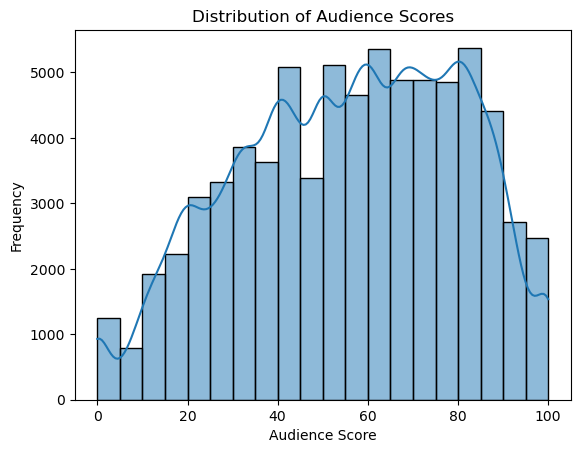

Skewness: -0.22568648273306127
Mean: 55.67496723460026
Median: 57.0
Mode: 50.0


In [44]:
# Let's create a histogram to visualize the distribution
sns.histplot(movies_data['audienceScore'], kde=True, bins=20)
plt.xlabel('Audience Score')
plt.ylabel('Frequency')
plt.title('Distribution of Audience Scores')
plt.show()

# Calculate skewness
skewness = movies_data['audienceScore'].skew()

# Print the skewness, mean, and median
print("Skewness:", skewness)
print("Mean:", movies_data['audienceScore'].mean())
print("Median:", movies_data['audienceScore'].median())
print("Mode:", movies_data['audienceScore'].mode()[0])

In [45]:
# Calculate the mean and standard deviation of the 'audienceScore' column
mean_audienceScore = movies_data['audienceScore'].mean()
std_audienceScore = movies_data['audienceScore'].std()

# Generate random samples from a Gaussian distribution with the same mean and standard deviation
# Use the number of missing values as the size of the samples
num_missing_values = movies_data['audienceScore'].isnull().sum()
random_samples = np.random.normal(loc=mean_audienceScore, scale=std_audienceScore, size=num_missing_values)

# Fill the missing values with the generated random samples
missing_indices = movies_data['audienceScore'].isnull()
movies_data.loc[missing_indices, 'audienceScore'] = random_samples

In [46]:
movies_data.audienceScore.isna().sum()

0

- **Imputing `runtimeMinutes` (Movies)**

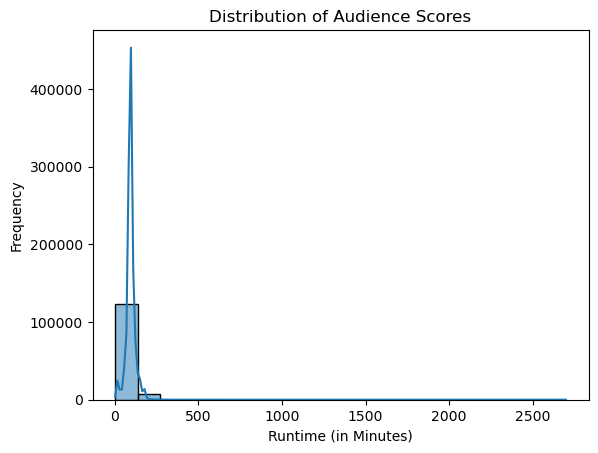

Skewness: 7.623215088141611
Mean: 93.70857831585941
Median: 92.0


In [47]:
# Let's create a histogram to visualize the distribution
sns.histplot(movies_data['runtimeMinutes'], kde=True, bins=20)
plt.xlabel('Runtime (in Minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Audience Scores')
plt.show()

# Calculate skewness
skewness_rm = movies_data['runtimeMinutes'].skew()

# Print the skewness, mean, and median
print("Skewness:", skewness_rm)
print("Mean:", movies_data['runtimeMinutes'].mean())
print("Median:", movies_data['runtimeMinutes'].median())

- Here we can observe that the Skew for the above distribution of `runtimeMinutes` is slightly higher which is 7.63 and the by the distribution we can infer that the data is `Positively Skewed` so we can use `Winsorization` a technique of Imputation that deals with missing data by filling the missing values with the `95th Percentile Value`.

In [48]:
# Calculate the value at the 95th percentile using Pandas
percentile_value_runtimeMinutes = movies_data['runtimeMinutes'].quantile(0.95)
print("Value at 95th percentile:", percentile_value_runtimeMinutes)

Value at 95th percentile: 137.0


In [49]:
imp_constant_95percentile = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=137)
movies_data.runtimeMinutes = pd.DataFrame(imp_constant_95percentile.fit_transform(np.array(movies_data.runtimeMinutes).reshape(-1,1)))

In [50]:
movies_data.runtimeMinutes.isna().sum()

0

- **Imputing `genre` and `originalLanguage` (Train)**

In [51]:
imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
movies_data.genre = pd.DataFrame(imp_mf.fit_transform(np.array(movies_data.genre).reshape(-1,1)))
movies_data.originalLanguage = pd.DataFrame(imp_mf.fit_transform(np.array(movies_data.originalLanguage).reshape(-1,1)))

In [52]:
movies_data.isna().sum()

movieid                 0
title                   0
audienceScore           0
releaseDateStreaming    0
runtimeMinutes          0
genre                   0
originalLanguage        0
director                0
dtype: int64

In [53]:
movies_data = movies_data.drop_duplicates(subset=['movieid'], keep='first')
movies_data

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.000000,2018.0,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,85.236784,2020.0,114.0,Drama,English,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.000000,2017.0,120.0,Drama,Korean,Theresa Smith
3,elegant_hermione_granger,Elegant Hermione Granger,60.000000,2020.0,90.0,"Action, Mystery & thriller",English,Donald Lewis
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.000000,2017.0,80.0,"Fantasy, Adventure, Animation",English,Howard Simms
...,...,...,...,...,...,...,...,...
143252,james_bond_jason_bourne,James Bond Jason Bourne,44.761549,2019.0,131.0,"Action, Mystery & thriller",Hindi,Reginald Davis
143253,sherlock_holmes_surreal_james_bond,Sherlock Holmes Surreal James Bond,14.000000,2017.0,90.0,"Action, Adventure, Anime",Japanese,William Sims
143254,mr._miyagi_katniss_everdeen_harmony,Mr. Miyagi Katniss Everdeen Harmony,33.733118,2017.0,99.0,Drama,English,Robert Paddock
143255,elegant_emerald_valiant_donnie_darko,Elegant Emerald Valiant Donnie Darko,71.000000,2017.0,43.0,Documentary,English,Roy Lovelace


In [54]:
merged_train = pd.merge(train, movies_data, on='movieid',how='left')
merged_train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,isMissingReview,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,marvelous_pirate,Benjamin Henry,False,henri selick s first movie since s coraline hi...,POSITIVE,False,Marvelous Pirate,65.000000,2022.0,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,with a cast that read like the vogue oscar par...,NEGATIVE,False,Tony Montana Frodo Baggins V Rocky Balboa,26.902689,2013.0,91.0,Action,English,Alma White
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,"cree ii doe not g us anyth but another, slight...",POSITIVE,False,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.000000,2019.0,130.0,Drama,English,Bobby Oleary
3,lara_croft_glimmer,Ryan Barrett,False,"i know what y re thinking, but thi is no limit...",POSITIVE,False,Lara Croft Glimmer,107.618519,2020.0,15.0,Drama,Spanish,Eric Hutcherson
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,director fernando meirelle tell the stori with...,POSITIVE,False,Jason Bourne Surreal The Terminator Indiana Jones,97.000000,2004.0,131.0,"Crime, Drama",Portuguese (Brazil),John Trent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,a top notch thrill with genuine surprise and a...,POSITIVE,False,The Joker Ethereal Captain Jack Sparrow Fantastic,52.514578,2004.0,96.0,Romance,English,Gertrude Fonner
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,some people find derek zooland funni and lik a...,NEGATIVE,False,E.T. Hannibal Lecter Vito Corleone Katniss Eve...,20.000000,2016.0,102.0,"Comedy, Adventure",English,Susan Oley
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"thi fun, gentle comedi focuse mainli on theme ...",POSITIVE,False,Infinite Enigma Luke Skywalker,78.000000,2022.0,90.0,"Comedy, Drama",English,Bryant Reams
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"the film is rescu by a strong third act, but g...",NEGATIVE,False,Emerald Oracle Iron Man Wolverine,39.000000,1998.0,88.0,"Kids & family, Holiday, Comedy",English,Lisa Cruz


In [55]:
test = test.rename({'isTopCritic':'isFrequentReviewer'}, axis=1)

In [56]:
merged_test = pd.merge(test, movies_data, on='movieid', how='left')
merged_test

,movieid,reviewerName,isFrequentReviewer,reviewText,isMissingReview,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,legend_marty_mcfly_oracle,John Kim,False,green slowli crank up the dread with style and...,False,Legend Marty McFly Oracle,57.000000,2022.0,111.0,"Holiday, Horror, Mystery & thriller",English,Sara Barnett
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,"philip noyce s direct is eleg and unforced, wi...",False,Terminator Katniss Everdeen Glimmer,86.000000,2003.0,94.0,"Drama, Adventure",English,Cindy Flander
2,james_bond_labyrinth_gollum,Danielle Parker,False,it wouldn t do to say what path maria ultimate...,False,James Bond Labyrinth Gollum,62.000000,2017.0,137.0,Drama,French,Charlotte Bramble
3,v_quest_han_solo_wondrous,Brittany Lane,False,pig is not exactli the arthouse john wick that...,False,V Quest Han Solo Wondrous,84.000000,2021.0,92.0,"Drama, Mystery & thriller",English,Jean Gainer
4,enigma_hulk_surreal_starlight,Justin Willis,False,an imagin no budget mus of sort about male sam...,False,Enigma Hulk Surreal Starlight,46.272185,2017.0,66.0,"Drama, Musical",Arabic,Marvin Short
...,...,...,...,...,...,...,...,...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,ron howard deliv an unconve rom comedi that s ...,False,Celestial Radiant,29.000000,2011.0,111.0,Comedy,English,Jill Fraser
55311,vivid_james_t._kirk,Thomas Osborne,False,as an oddball art film that openli invite y to...,False,Vivid James T. Kirk,71.000000,2013.0,116.0,"Comedy, Drama, Fantasy",English,Daryl Wilson
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,nicholson wear hi devilish grin from hi first ...,False,Scarlett O'Hara Neo Scarlett O'Hara Infinite,60.000000,2003.0,106.0,Comedy,English,Maria Tejada
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,it s hard not be entertain by two dozen of col...,False,Terminator Epic Rocky Balboa Mystic,65.000000,2004.0,125.0,"Musical, Biography, Drama, Lgbtq+",English,Jermaine Fantasia


### Shapes of Train and Test Data for Model Building and Predictions 

In [57]:
print(merged_train.shape, merged_test.shape)

(162758, 13) (55315, 12)


## Data and Label Matrix

In [58]:
X_train = merged_train.drop('sentiment', axis=1)
y_train = merged_train.sentiment
X_train.shape, y_train.shape

((162758, 12), (162758,))

In [59]:
X_test = merged_test
X_test.shape

(55315, 12)

In [60]:
X_train

,movieid,reviewerName,isFrequentReviewer,reviewText,isMissingReview,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
0,marvelous_pirate,Benjamin Henry,False,henri selick s first movie since s coraline hi...,False,Marvelous Pirate,65.000000,2022.0,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,with a cast that read like the vogue oscar par...,False,Tony Montana Frodo Baggins V Rocky Balboa,26.902689,2013.0,91.0,Action,English,Alma White
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,"cree ii doe not g us anyth but another, slight...",False,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.000000,2019.0,130.0,Drama,English,Bobby Oleary
3,lara_croft_glimmer,Ryan Barrett,False,"i know what y re thinking, but thi is no limit...",False,Lara Croft Glimmer,107.618519,2020.0,15.0,Drama,Spanish,Eric Hutcherson
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,director fernando meirelle tell the stori with...,False,Jason Bourne Surreal The Terminator Indiana Jones,97.000000,2004.0,131.0,"Crime, Drama",Portuguese (Brazil),John Trent
...,...,...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,a top notch thrill with genuine surprise and a...,False,The Joker Ethereal Captain Jack Sparrow Fantastic,52.514578,2004.0,96.0,Romance,English,Gertrude Fonner
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,some people find derek zooland funni and lik a...,False,E.T. Hannibal Lecter Vito Corleone Katniss Eve...,20.000000,2016.0,102.0,"Comedy, Adventure",English,Susan Oley
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"thi fun, gentle comedi focuse mainli on theme ...",False,Infinite Enigma Luke Skywalker,78.000000,2022.0,90.0,"Comedy, Drama",English,Bryant Reams
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"the film is rescu by a strong third act, but g...",False,Emerald Oracle Iron Man Wolverine,39.000000,1998.0,88.0,"Kids & family, Holiday, Comedy",English,Lisa Cruz


In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
# X_train.genre = X_train.genre.map(lambda x: [i.strip() for i in x.split(",")])
# X_test.genre = X_test.genre.map(lambda x: [i.strip() for i in x.split(",")])

In [63]:
# mlb = MultiLabelBinarizer(sparse_output=True)

In [64]:
# X_train_genres = mlb.fit_transform(X_train.genre)
# X_train_genres

In [65]:
# X_test_genres = mlb.transform(X_test.genre)
# X_test_genres

In [66]:
ct = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words = 'english', max_features=30000,ngram_range=(1,2), strip_accents='ascii'), 'reviewText'),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'),['reviewerName', 'isFrequentReviewer', 'director', 'originalLanguage', 'title','releaseDateStreaming','genre']),
    ("num_preprocess", MinMaxScaler(), ['audienceScore', 'runtimeMinutes'])
])

In [67]:
X_train_ = ct.fit_transform(X_train)
X_test_ = ct.transform(X_test)

In [68]:
X_train_

<162758x62060 sparse matrix of type '<class 'numpy.float64'>'
	with 3529051 stored elements in Compressed Sparse Row format>

In [69]:
X_test_

<55315x62060 sparse matrix of type '<class 'numpy.float64'>'
	with 1184263 stored elements in Compressed Sparse Row format>

In [70]:
# from scipy.sparse import hstack
# X_train_ = hstack((X_train_, X_train_genres))
# X_test_ = hstack((X_test_, X_test_genres))

In [71]:
X_train_, X_test_

(<162758x62060 sparse matrix of type '<class 'numpy.float64'>'
 	with 3529051 stored elements in Compressed Sparse Row format>,
 <55315x62060 sparse matrix of type '<class 'numpy.float64'>'
 	with 1184263 stored elements in Compressed Sparse Row format>)

In [72]:
# from sklearn.model_selection import train_test_split as tts
# X_train_, X_test_, y_train, y_test = tts(X_train_,y_train,test_size=0.2,random_state=42)

# **Models**

In [73]:
def apply(model):
    model.fit(X_train_, y_train)
    predicted_test = model.predict(X_test_)
    predicted_train = model.predict(X_train_)
    try:
        print("Train:\n",classification_report(y_train, predicted_train))
        print("Test:\n",classification_report(y_test, predicted_test))
        print("Train:",f1_score(y_train, predicted_train, average='micro'))
        print("Test:",f1_score(y_test, predicted_test, average='micro'))
    except Exception as e:
        print(e)
        pass
    return predicted_test

## **1. LogisticRegression**

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
logreg = LogisticRegression(C=1, n_jobs=-1, solver='saga', random_state=69)

In [76]:
# apply(logreg)

## **2. LinearSVC**

In [77]:
from sklearn.svm import LinearSVC

In [78]:
lsvc = LinearSVC(penalty = 'l2', loss= 'squared_hinge', C=1,random_state=69)

In [79]:
# apply(lsvc)

## **3. XGBoost Classifier**

In [80]:
from xgboost import XGBClassifier

In [81]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_enc = le.fit_transform(y_train)
# y_test_enc = le.fit_transform(y_test)

In [82]:
xgb = XGBClassifier()

In [83]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [0.8, 0.9],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2]
# }

# random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10,scoring='f1_micro', cv=3, verbose=2, random_state=42)

## **4. Stacking Classifier**

In [84]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB

In [85]:
estimators = [
    ('lsvc', LinearSVC(penalty = 'l2', loss= 'squared_hinge', C=1,random_state=69)),
    ('xgb', XGBClassifier(n_estimators = 200)),
    ('mnb', MultinomialNB())
]

In [86]:
st_clf = StackingClassifier(
    estimators=estimators, final_estimator = LogisticRegression(C=1, n_jobs=-1, solver='saga', random_state=69), n_jobs=-1
)

In [87]:
print("Stacking Classifier")

Stacking Classifier


In [88]:
predicted_stack = apply(st_clf)

Train:
               precision    recall  f1-score   support

    NEGATIVE       0.89      0.80      0.84     53997
    POSITIVE       0.90      0.95      0.93    108761

    accuracy                           0.90    162758
   macro avg       0.90      0.87      0.88    162758
weighted avg       0.90      0.90      0.90    162758

name 'y_test' is not defined


## **Submission File**

In [89]:
submission = pd.DataFrame(columns=['id','sentiment'])
submission['id'] = [i for i in range(len(predicted_stack))]
submission['sentiment'] = pd.DataFrame(predicted_stack)
submission.to_csv("submission.csv", index=False)
submission

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE
